The basis of this is these demand curves generated based on a base model run with no subsidies implemented.

This shows the break-even green H2 price for each sector/technology for select years. Focus on early years for fast change.

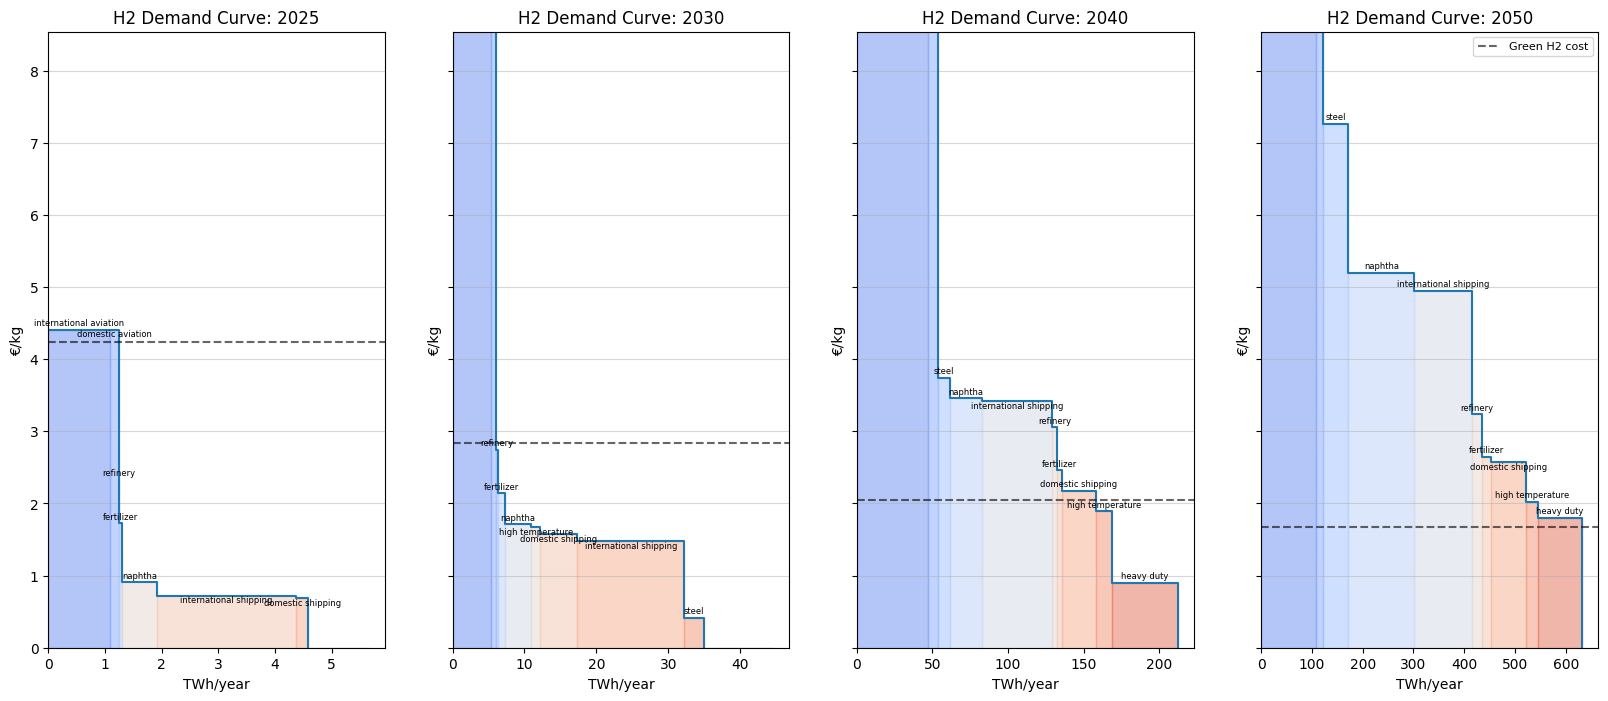

## Initialization

### Preample

In [74]:
import pysd
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
#from IPython.parallel import Client
from time import time
from tqdm import tqdm

### Load Vensim model

In [75]:
cwd = os.getcwd()
model_name = "hydrogen_model"
model_short_path = "vensim_models/" + model_name

model_loaded = False # Set to True if the model is loaded from a Python file # Saves some time when reloading an unchanged version of the model

start = time()
if model_loaded: # Load the model from the Python file
    model_file = os.path.join(cwd, model_short_path + ".py")
    model = pysd.load(model_file)
else: # Read the model from the Vensim mdl file
    model_file = os.path.join(cwd, model_short_path + ".mdl")
    model = pysd.read_vensim(model_file, split_views = True)

print("Model loaded in {} seconds".format(np.round(time()-start,3)))

Model loaded in 19.0 seconds


### Load dicts and lists required to easily extract results

In [76]:
from python_scripts.result_loading import result_loading_class

rl = result_loading_class()

### Load input data 

In [77]:
from python_scripts.data_loading import data_loading_class # Import the data_loading_class from the data_loading.py file, which enables easy access to data from the different data sources

### ------- Load new data ------- ###
dl = data_loading_class()
# All data is loaded with function calls to the data_loading_class.
# **kwargs can be used for "sensitivity" : float, which scales the data with a factor

# Fossil fuels:
gas_prices = dl.load_gas_prices()
oil_prices = dl.load_oil_prices()
coal_prices = dl.load_coal_prices()

# Biomass:
woodchip_prices = dl.load_woodchip_prices()
straw_prices = dl.load_straw_prices()
woodpellet_prices = dl.load_woodpellet_prices()

# Electricity:
electricity_prices = dl.load_electricity_prices()

### Setup Base Model

In [78]:
basemodel = model.copy()

### ------- Load data in model - if the original model should be saved use model.copy() to copy the current version of the  ------- ###
basemodel.set_components({"GAS PRICE LOOKUP": gas_prices,
                                    "OIL PRICE LOOKUP": oil_prices,
                                    "COAL PRICE LOOKUP": coal_prices,
                                    "BIOMASS PRICE LOOKUP": woodchip_prices,
                                    "CARBON TAX LOOKUP": dl.load_carbon_taxes(),
                                    "Green H2 subsidy size": 0,}) #, "ELECTRICITY PRICE LOOKUP": electricity_prices})

### Run Base Model

In [79]:
basemodel_results = basemodel.run()

### Sensitivity run functions

In [90]:
def run_sensitivity(variable, values, basemodel_sens):
    sens_models = {}
    sens_models["base"] = basemodel
    sens_results = {}
    sens_results["base"] = basemodel_results
    scenarios = []
    for val in tqdm(values, desc="Running sensitivity analysis: " + variable):
        name =  variable + " = " + str(val)
        scenarios.append(name)
        sens_models[name] = basemodel_sens.copy()
        sens_models[name].set_components({variable: val}) 
        sens_results[name] = sens_models[name].run()
    return sens_results, sens_models, scenarios

In [98]:
# Function for plotting results of a parameter for different scenarios
def plot_sens_results(sens_results : dict, parameters : list):
    fig, axs = plt.subplots(1, len(parameters), figsize = (5 * len(parameters), 5))
    for ix in range(len(parameters)):
        parameter = parameters[ix][0]
        unit = parameters[ix][1]
        for i in sens_results:
            axs[ix].plot(sens_results[i][parameter], label = i)
        axs[ix].legend(fontsize=6)
        axs[ix].set_title(parameter)
        axs[ix].set_xlabel("Year")
        axs[ix].set_ylabel(unit)
        axs[ix].set_xlim(2022, 2050)
        axs[ix].set_ylim(0)
        axs[ix].grid(alpha=0.5)
    plt.show()

In [95]:
def co2_efficiency_plotter(sens_results, scenarios):
    # Calculate the subsidy cost per tCO2 saved
    fig, ax = plt.subplots(figsize=(6,4))
    subsidy_cost_per_tCO2 = {}
    for i in scenarios:
        subsidy_cost_per_tCO2[i] = sens_results[i]["TOTAL SUBSIDIES"].iloc[-1] / (sens_results["base"]["TOTAL EMISSIONS"].iloc[-1] - sens_results[i]["TOTAL EMISSIONS"].iloc[-1])
    plt.bar(subsidy_cost_per_tCO2.keys(),np.array(list(subsidy_cost_per_tCO2.values()))*10**6)
    plt.title("Subsidy cost per tCO2 annual emissions reduction")
    plt.xticks(rotation=90)
    plt.xlabel("Scenario")
    plt.ylabel("[€/(tCO2/year)]")
    plt.grid(axis='y')

## Subsidy Runs

**Variables/objects of interest from initialization:**

basemodel: Object which represents the model which can be copied, modified, and run.

basemodel_results: DataFrame with base model results without subsidies.

rl: result_loader Object with lists and dicts used to extract results from basemodel_results or other runs.

In [100]:
stocks = ["H2 DEMAND in TWh", "Green H2 cost", "TOTAL SUBSIDIES", "TOTAL EMISSIONS"]
units = ["TWh", "€/kg", "M€", "tCO2"]
params = [(stocks[i], units[i]) for i in range(len(units))]

#### Different sizes of subsidies:

In [101]:
subsidy_sizes = [0.5, 1, 1.5, 2, 2.5, 3]
subsize_results, subsize_models, subsize_scenarios = run_sensitivity("Green H2 subsidy size", subsidy_sizes, basemodel)

Running sensitivity analysis: Green H2 subsidy size: 100%|██████████| 6/6 [01:24<00:00, 14.10s/it]


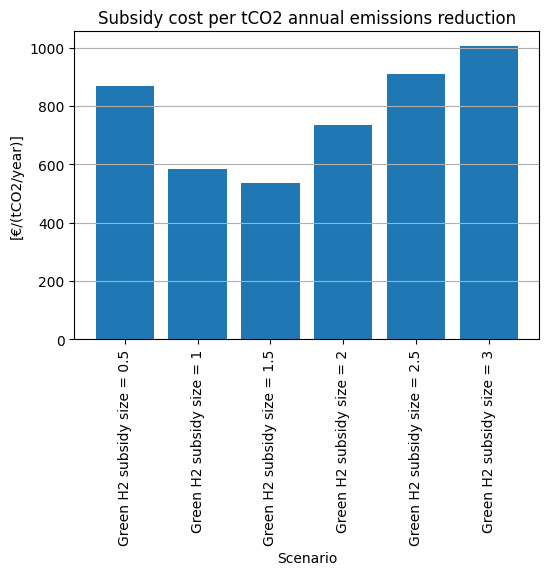

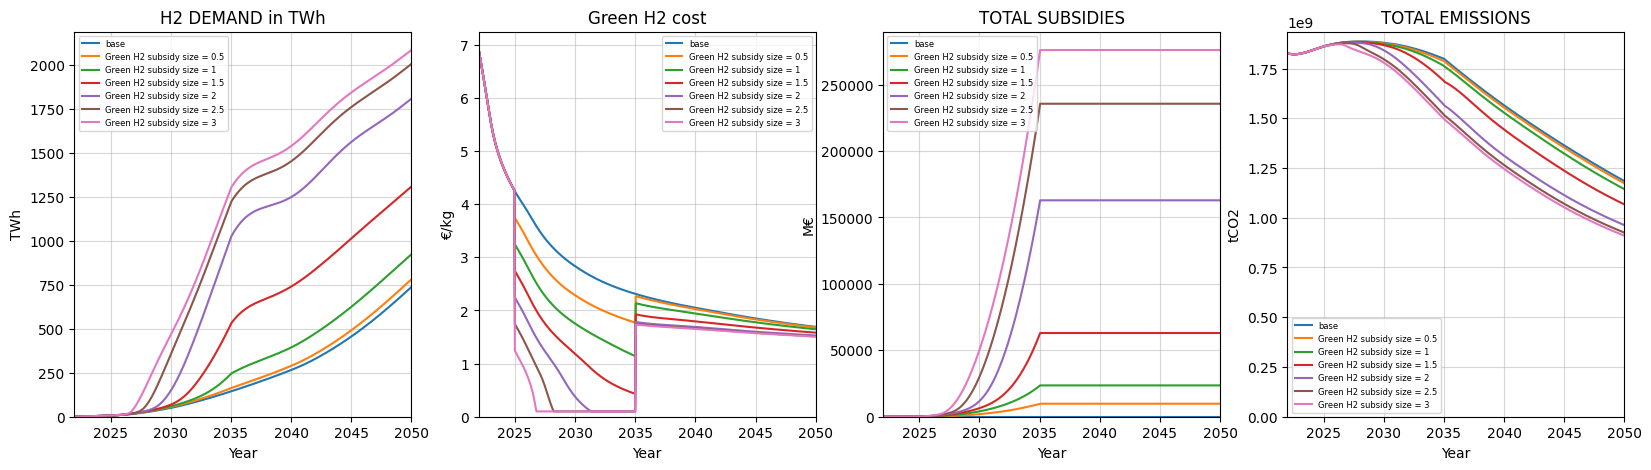

In [102]:
co2_efficiency_plotter(subsize_results, subsize_scenarios)
plot_sens_results(subsize_results, params)

#### Different length of subsidies

In [103]:
subsidy_length_model = basemodel.copy()
subsidy_length_model.set_components({"Green H2 subsidy size": 2})

subsidy_lengths = [5, 10, 15, 20, 25] # years
sublen_results, sublen_models, sublen_scenarios = run_sensitivity("H2 subsidy length", subsidy_lengths, subsidy_length_model)

Running sensitivity analysis: H2 subsidy length: 100%|██████████| 5/5 [01:03<00:00, 12.69s/it]


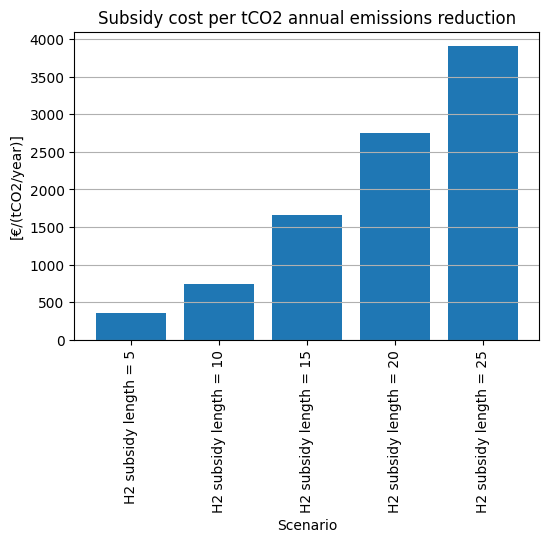

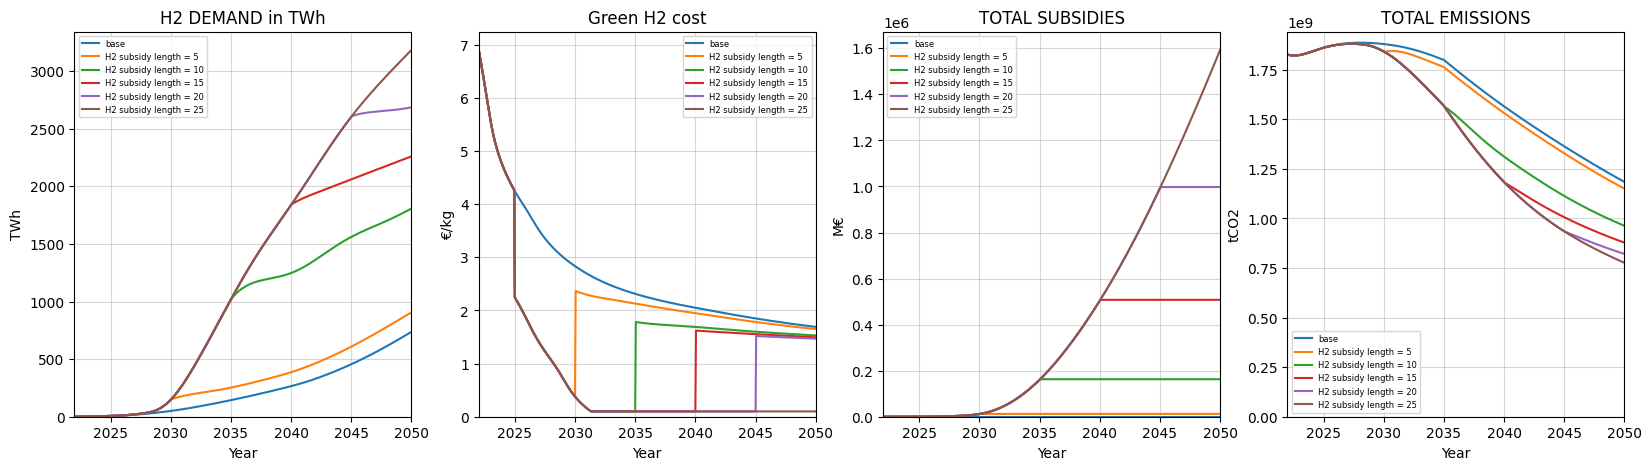

In [104]:
co2_efficiency_plotter(sublen_results, sublen_scenarios)
plot_sens_results(sublen_results, params)

#### Subsidizing specific sectors

In [105]:
subsidy_sizes = [0.5, 1, 1.5, 2, 2.5, 3]
subsize_results, subsize_models, subsize_scenarios = run_sensitivity("NH3 H2 subsidy size", subsidy_sizes, basemodel)
subsize_results, subsize_models, subsize_scenarios = run_sensitivity("refinery H2 subsidy size", subsidy_sizes, basemodel)

Note: you may need to restart the kernel to use updated packages.
